In [1]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

######import scienceplots
import cmasher as cmr
plt.style.use('science')
import jax.random as random 
from matplotlib.patches import Ellipse
import time

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)

from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
import numpy as np

from jax.scipy.special import sph_harm, gammaln, gamma
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jax.scipy.stats import gaussian_kde
#import run_falcon as run
from scipy.special import factorial as factorial_true
from scipy.special import gamma as gamma_sp

In [2]:
import sympy
import sympy2jax


In [3]:
gamma_sp(-2.3)

-1.4471073942559183

In [4]:
class Gegenbauer:
    def __init__(self,nmax):
        self.nmax = nmax
        self.x_sym = sympy.symbols("x_sym")
        self.n_sym = sympy.symbols("n_sym")
        self.alpha_sym = sympy.symbols("alpha_sym")
        self.deriv_arg = (1-self.x_sym**2)**(self.n_sym+self.alpha_sym - 0.5)
        #self.func_list = []
        self.gen_nth_deriv()

    @partial(jax.jit,static_argnums=(0,))
    def factorial(self,n):
        """
        factorial helper function.
        n MUST be int, not float!
        """
        ###print(n.shape)
        n = n[0]
        return gamma(n+1.0)  #n! = gamma(n+1)
        
        ###curr = jnp.array(1)
        
        ###def body_func(i,curr):
        ###    return curr*i
        ###return jax.lax.fori_loop(jnp.array(1),n+1,body_func,curr)

    def gen_nth_deriv(self):
        self.func_list = []
        for i in range(self.nmax+1):
            fun_sympy = sympy.simplify(sympy.diff(self.deriv_arg,self.x_sym,i))
            fun_jax = sympy2jax.SymbolicModule(fun_sympy)  
            fun_jax_save = lambda x, alpha, i=i, fun_jax=fun_jax: fun_jax(x_sym=x,alpha_sym=alpha,n_sym=i)
            self.func_list.append(fun_jax_save)
    
    @partial(jax.jit,static_argnums=(0,))
    def takefunc(self,n,alpha,x):
        n = n[0]
        #ops = {'x_sym':x, 'n_sym':n, 'alpha_sym':alpha}
        return jax.lax.switch(n,self.func_list,x,alpha)

    #@partial(jax.jit,static_argnums=(0,))
    def C_n_alpha(self,n,alpha,x):
        #n = jnp.array([jax.lax.cond(n[0] > self.nmax,
        #                lambda x: jax.lax.stop_gradient(jax.lax.stop_gradient(x))*0,
        #                lambda x: x,
        #                operand=n[0])])
        nth_deriv = self.takefunc(n=n,alpha=alpha,x=x) #self.func_list[n](x=x,alpha=alpha) 
        prefac_front0 = ((-1.0)**n)/( (2**n)*self.factorial(n) )
        prefac_front1 = (gamma(alpha+0.5)*gamma(n+2.0*alpha)) / (gamma(2.0*alpha)*gamma(alpha+n+0.5))
        #jnp.exp( gammaln(alpha + 0.5) + gammaln(n + 2.0*alpha) - ( gammaln(2*alpha) + gammaln(alpha + n + 0.5) ) )
        prefac_front2 = (1.0-x**2)**(-alpha + 0.5)
        return prefac_front0*prefac_front1*prefac_front2*nth_deriv#self.func_list[n](x_sym=x,n_sym=n,alpha_sym=alpha)
        

    
            
UltraSph = Gegenbauer(6)      
    

In [5]:
UltraSph.C_n_alpha(n=jnp.array([5]),alpha=2*0+(3./2),x=jnp.linspace(0.02,.99,10000)).sum()

Array(11453.52170258, dtype=float64)

In [6]:
from scipy.special import gegenbauer as gegenbauer_sp
gegenbauer_sp(n=5,alpha=2*0 + (3/2))(np.linspace(0.02,.99,10000)).sum()

11453.521702584716

In [7]:
class BFE:
    def __init__(self,nmax,lmax,xyz,mass):
        self.nmax = nmax#+1
        self.lmax = lmax#+1
        self.xyz = xyz
        self.mass = mass
        self.r, self.theta, self.phi = self.cart2sph(self.xyz)
        self.ultra_sph = Gegenbauer(self.nmax) 
        
    @partial(jax.jit,static_argnums=(0,))
    def cart2sph(self,xyz):
        r = jnp.sqrt(jnp.sum(xyz**2,axis=1))#jnp.sqrt(x**2 + y**2 + z**2)
        R = jnp.sqrt(jnp.sum(xyz[:,:2]**2,axis=1))
        theta = jnp.arccos(xyz[:,-1] / r) #jnp.arctan2(R, xyz[:,-1])#
        phi = jnp.arctan2(xyz[:,1], xyz[:,0])
    
        # Ensure theta is in [0, pi] and phi is in [0, 2*pi]
        ########theta = jnp.where(theta <= jnp.pi, theta, 2*jnp.pi - theta)
        phi = jnp.where(phi >= 0, phi, 2*jnp.pi + phi)
    
        return r, theta, phi
        
    @partial(jax.jit,static_argnums=(0,))
    def factorial(self,n):
        """
        factorial helper function.
        n MUST be int, not float!
        """
        n = n[0]
        return gamma(n+1.0)  #n! = gamma(n+1)
        
    
    @partial(jax.jit,static_argnums=(0,))
    def Knl(self,n,l):
        return 0.5*n*(n+4*l+3.) + (l+1)*(2*l+1)

    @partial(jax.jit,static_argnums=(0,))###
    def rho_nl(self,n,l,r):
        psi = (r-1.0)/(r+1.0)
        prefac =  (self.Knl(n=n,l=l)/(2*jnp.pi))*( (r**l) / (r*((1+r)**(2*l+3))) )*self.ultra_sph.C_n_alpha(x=psi,n=n,alpha=2*l + (3.0/2))#(self.Knl(n,l)/(2*jnp.pi))*( (r**l) / (r*((1+r)**(2*l+3))) )*self.ultra_sph.C_n_alpha(x=psi,n=n,alpha=2*l + (3/2))
        return jnp.sqrt(jnp.pi*4)*prefac
    
    @partial(jax.jit,static_argnums=(0,))####
    def phi_nl(self,n,l,r):
        psi = (r-1.0)/(r+1.0)
        prefac = -( (r**l) / (1.0*((1.0+r)**(2*l +1 ))) )*self.ultra_sph.C_n_alpha(x=psi,n=n,alpha=2*l + (3.0/2)) #l[0]  # r in denominator disagrees between Lowell 2011 and Garavito-Camargo
        return jnp.sqrt(jnp.pi*4)*prefac

    @partial(jax.jit,static_argnums=(0,))
    def Atilde(self,n,l):
        prefac = -(2**(8.0*l + 6))/(4*jnp.pi*self.Knl(n,l))
        arg = gamma(2*l + (3./2))
        num = self.factorial(n)*(n + 2*l + (3./2))*( ( arg )**2 )
        denom = gamma(n + 4.0*l + 3.0)#jnp.exp( gammaln(n + 4*l + 3.0) )
        return prefac*(num/denom)

    @partial(jax.jit,static_argnums=(0,))
    def get_Ylm(self, l,m,theta_,phi_):
        """
        Scipy convention: first arg is m, second is l.  l \in [0,lmax], m \in [0,l]
        So n ~ l here in scipy and n_max ~ l_max
        n_max must be statically set
        """
        #included_prefac = jnp.sqrt( ( (2.0*l + 1.0)/(4.0*jnp.pi) )*( self.factorial(l-m) / self.factorial(l+m) ) )
        return jnp.real(sph_harm(m=m, n=l, theta=phi_, phi=theta_,n_max=25))/jnp.cos(m*phi_)#((jax.lax.complex(jnp.cos(m*phi_), jnp.sin(m*phi_)) ) ) )
#sph_harm(m=m, n=l, theta=theta, phi=phi,n_max=12)
        
    @partial(jax.jit,static_argnums=(0,))
    def check_m_zero(self,m):
        m = m[0]
        result = jax.lax.cond(m == 0, lambda _: 1, lambda _: 0, None)
        return result
                
    @partial(jax.jit,static_argnums=(0,))
    def Snlm_single(self, n, l, m):
        delta_m0 = self.check_m_zero(m)
        delta_prefac = (2.0 - delta_m0)
        return delta_prefac*self.Atilde(n=n,l=l)*jnp.sum( self.mass*self.phi_nl(n=n,l=l, r=self.r)*self.get_Ylm(l=l,m=m,theta_=self.theta,phi_=self.phi)*jnp.cos(m*self.phi) )

    @partial(jax.jit,static_argnums=(0,))
    def Tnlm_single(self,n,l,m):
        delta_m0 = self.check_m_zero(m)
        delta_prefac = (2.0 - delta_m0)
        return delta_prefac*self.Atilde(n=n,l=l)*jnp.sum( self.mass*self.phi_nl(n=n,l=l, r=self.r)*self.get_Ylm(l=l,m=m,theta_=self.theta,phi_=self.phi)*jnp.sin(m*self.phi) )

    @partial(jax.jit,static_argnums=(0,))
    def phi_rho(self, r_eval, theta_eval, phi_eval):
        phi_val = 0.0
        rho_val = 0.0
        for n_ind in range(0,self.nmax+1):
            n = jnp.array([n_ind])
            for l_ind in range(0,self.lmax+1):
                l = jnp.array([l_ind])
                rho_nl_val = self.rho_nl(n,l,r_eval)
                phi_nl_val = self.phi_nl(n,l,r_eval)
                for m_ind in range(0,l_ind+1):
                    m = jnp.array([m_ind])
                    ylm_val = self.get_Ylm(l=l,m=m,theta_=theta_eval,phi_=phi_eval)
                    Snlm_val = self.Snlm_single(n=n,l=l,m=m)
                    Tnlm_val = self.Tnlm_single(n=n,l=l,m=m)
                    cos_mphi = jnp.cos(m*phi_eval)
                    sin_mphi = jnp.sin(m*phi_eval)
                    sine_cos_part = Snlm_val*cos_mphi + Tnlm_val*sin_mphi
                    
                    rho_val += ylm_val*rho_nl_val*( sine_cos_part )
                    phi_val += ylm_val*phi_nl_val*( sine_cos_part )
        
        return jnp.real(phi_val), jnp.real(rho_val)

    @partial(jax.jit,static_argnums=(0,))
    def potential(self, r_eval, theta_eval, phi_eval):
        return self.phi_rho(r_eval,theta_eval,phi_eval)[0][0]

    @partial(jax.jit,static_argnums=(0,))
    def density(self, r_eval, theta_eval, phi_eval):
        return self.phi_rho(r_eval,theta_eval,phi_eval)[1][0]

    @partial(jax.jit,static_argnums=(0,))
    def potential_cart(self, xyz_eval):
        r_eval, theta_eval, phi_eval = self.cart2sph(xyz_eval)
        return self.phi_rho(r_eval,theta_eval,phi_eval)[0][0]

    @partial(jax.jit,static_argnums=(0,))
    def density_cart(self, xyz_eval):
        r_eval, theta_eval, phi_eval = self.cart2sph(xyz_eval)
        return self.phi_rho(r_eval,theta_eval,phi_eval)[1][0]
        
        
## Example
np.random.seed(4030)
xyz = jnp.array(np.random.normal(0,3,(1000,3)))
nmax = 2
lmax = 2#2
mass_arr = jnp.ones(len(xyz))#jnp.array(np.random.normal(2000,2001,(len(xyz))))
mass_arr = mass_arr/mass_arr.sum()
obj = BFE(nmax,lmax,xyz,mass_arr)

In [8]:
obj.Snlm_single(n =jnp.array([1]),l=jnp.array([1]),m=jnp.array([1]))

Array([-0.00438039], dtype=float64)

In [9]:
import ctypes

# Load the GSL library
gsl = ctypes.CDLL('/usr/local/Cellar/gsl/2.7.1/lib/libgsl.27.dylib')  # Adjust the library name and version as needed
# Define the function signature for gsl_sf_legendre_sphPlm
gsl_sf_legendre_sphPlm = gsl.gsl_sf_legendre_sphPlm
gsl_sf_legendre_sphPlm.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.c_double]
gsl_sf_legendre_sphPlm.restype = ctypes.c_double


#gsl_sf_gamma = gsl.gsl_sf_gamma
#gsl_sf_gamma.argtypes =  [ctypes.c_int]#[ctypes.c_int, ctypes.c_double]
#gsl_sf_gamma.restype = ctypes.c_double


# Example usage
l = 2
m = 1
x = 0.9
result = gsl_sf_legendre_sphPlm(l, m, x)
print(f"P_{l}^{m}({x}) = {result}")

P_2^1(0.9) = -0.3030714380008618


In [10]:
gsl_sf_gamma(.3,)

NameError: name 'gsl_sf_gamma' is not defined

In [11]:
obj.get_Ylm(l=jnp.array([l]),m=jnp.array([m]),theta_=jnp.arccos(x),phi_=.20)

Array([-0.30307144], dtype=float64)

In [12]:
jnp.abs((obj.Snlm_single(n =jnp.array([1]),l=jnp.array([1]),m=jnp.array([1])) - S)/S).min()

NameError: name 'S' is not defined

In [13]:
obj.Snlm_single(n =jnp.array([1]),l=jnp.array([1]),m=jnp.array([1]))-S[1,1,1] 

NameError: name 'S' is not defined

In [26]:
phi_curr, rho_curr = obj.phi_rho(10.,.9,.2)

In [27]:
phi_curr, rho_curr

(Array([-0.11390222], dtype=float64), Array([4.40549139e-05], dtype=float64))

In [30]:
from gala.potential import scf
#mass = np.ones(n_samples) / n_samples
S,T = scf.compute_coeffs_discrete(np.array(xyz), mass=np.array(mass_arr), nmax=2, lmax=2, 
                                  skip_odd = False,skip_even=False,skip_m=False,r_s=1.)
pot_gala = gp.SCFPotential(m=1.,r_s=1.,Snlm=S,Tnlm=T,units=usys)


In [31]:
phi_curr


Array([-0.11390222], dtype=float64)

In [32]:
pot_gala([10.,.9,.2])

<Quantity [-4.70091691e-13] kpc2 / Myr2>

In [384]:
S.max()

1.2387788316431765

In [385]:
#obj.density_cart(jnp.array([[1.,2.,3.]]))
x_lin = jnp.linspace(-2,2,100)
X,Y = jnp.meshgrid(x_lin,x_lin)
Z = X*0.0
xyz_eval = jnp.vstack([X.flatten(),Y.flatten(),Z.flatten()]).T
xyz_eval = xyz_eval.reshape(len(xyz_eval),1,3)
test = jax.vmap(obj.density_cart,in_axes=((0,)))(xyz_eval)

In [386]:
test

Array([0.00124225, 0.00128323, 0.00132546, ..., 0.00132546, 0.00128323,
       0.00124225], dtype=float64)

In [387]:
xyz_eval.shape

(10000, 1, 3)

In [388]:
s = time.time()
test = jax.vmap(obj.density_cart,in_axes=((0,)))(xyz_eval)
e = time.time()
print(e-s)

0.3781118392944336


In [389]:
s = time.time()
test = jax.vmap(obj.potential_cart,in_axes=((0,)))(xyz_eval)
e = time.time()
print(e-s)

2.3506250381469727


In [390]:
den = np.array(test)#.shape

In [391]:
den

array([-0.32357383, -0.32599418, -0.3284251 , ..., -0.3284251 ,
       -0.32599418, -0.32357383])

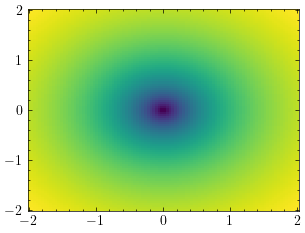

In [392]:
plt.pcolormesh(X,Y,1*den.reshape(X.shape),vmin=den.min(),vmax=den.max())

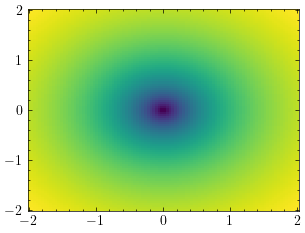

In [393]:
plt.pcolormesh(X,Y,1*pot_gala(xyz_eval[:,0,:].T).reshape(X.shape),rasterized=True,vmin=den.min(),vmax=den.max())
#@plt.xlim(-1,1)
#plt.ylim(-1,1)

In [394]:
np.isin(den,pot_gala(np.array(xyz_eval[:,0,:]).T)).sum()

0

In [395]:
err = (den-pot_gala(np.array(xyz_eval[:,0,:]).T))/pot_gala(np.array(xyz_eval[:,0,:]).T)

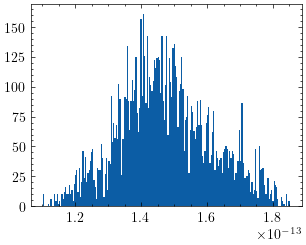

In [396]:
_=plt.hist(np.array(err)*100,bins=200)

In [397]:
err.max()*100

<Quantity 1.85050013e-13>

In [228]:
obj.Snlm_single(jnp.array([1]),jnp.array([1]),jnp.array([0]))

Array([0.04947844], dtype=float64)

In [229]:
S[0,0,0]

1.2387788316431765

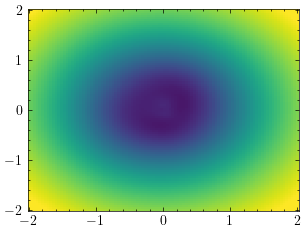

In [230]:
plt.pcolormesh(X,Y,1*pot_gala(xyz_eval[:,0,:].T).reshape(X.shape),rasterized=True,vmin=den.min(),vmax=den.max())
#@plt.xlim(-1,1)
#plt.ylim(-1,1)

In [306]:
obj.density_cart(jnp.array([[2,1.,3.]]))

Array(0.0003906, dtype=float64)

In [294]:
pot_gala = gp.SCFPotential(m=1.,r_s=1.,Snlm=S,Tnlm=T)
pot_gala.density(np.array([2,1.,3.]))/obj.density_cart(jnp.array([[2.,1.,3.]]))

<Quantity [7.3332633]>

In [132]:
xyz_eval.reshape(16,1,3).shape

TypeError: reshape total size must be unchanged, got new_sizes (16, 1, 3) for shape (1600, 1, 3).

In [54]:
phi_only = lambda r, theta, phi: obj.phi_rho(r, theta, phi)[0][0]
rho_only = lambda r, theta, phi: obj.phi_rho(r, theta, phi)[0][0]

In [62]:


jax.grad(phi_only,argnums=((0,1,2,)))(10.,.8,.2)

(Array(433.6454669, dtype=float64),
 Array(0., dtype=float64),
 Array(458.06604697, dtype=float64, weak_type=True))

In [47]:
jax.grad(phi_only)(jnp.array([1.,.2,.2]))

IndexError: tuple index out of range

In [59]:
rho_curr.shape

(1000,)

In [751]:
obj.ultraspherical_single_sum_element(3,.5,jnp.array([2]),.3)

Array([-0.23809524], dtype=float64)

In [730]:
@jax.jit
def rho(r, theta, phi):
    rho0 = 0.0
    for n in range(0,nmax):
        for l in range(0,lmax):
            for m in range(0,l):
                
                
    return a
    

#g = obj.Snlm_single(n=jnp.array([3]), l=jnp.array([2]), m=jnp.array([0]))


In [735]:
jax.grad(test_loop)(200.)

Array(1.96679398e-07, dtype=float64, weak_type=True)

In [688]:
gg = jnp.array([3])
gg[0]

Array(3, dtype=int64)

In [344]:
#obj.phi_nl(jnp.array([3]),jnp.array([2]))

In [706]:
obj.ultraspherical_single_sum_element(3,.5,jnp.array([2]),.3)

Array([-0.23809524], dtype=float64)

In [707]:
#jax.grad(obj.jitted_ulstraspherical_polynomials)(.5,3,.3)

In [745]:
s = time.time()
g = obj.Snlm_single(jnp.array([3]), jnp.array([2]), jnp.array([0]))
e = time.time()
print(e-s)

TypeError: BFE.phi_nl() missing 1 required positional argument: 'r'

In [690]:
#obj.Snlm_single(jnp.array([4]), jnp.array([5]), jnp.array([2]))

In [95]:
obj.factorial(jnp.array([2]))

Array(2, dtype=int64, weak_type=True)

In [10]:
obj.jitted_ulstraspherical_polynomials(jnp.array([.4]),jnp.array([2]),jnp.array([2]))

NameError: name 'ultraspherical_single_sum_element' is not defined

In [530]:
xyz.shape

(10, 3)

In [531]:
obj.phi_nl(jnp.array(2),jnp.array(1))

TypeError: body_fun output and input must have identical types, got
('ShapedArray(int64[], weak_type=True)', 'ShapedArray(int64[])', 'DIFFERENT ShapedArray(float64[10]) vs. ShapedArray(float64[])').

In [511]:
obj.ultraspherical_single_sum_element(jnp.array(3),jnp.array(.5),jnp.array([3]),4)

Array(-0.16666667, dtype=float64)

In [ ]:
obj.jitted_ulstraspherical_polynomials()

In [479]:
obj.Atilde(jnp.array([3]),jnp.array([2]))

Array([0.20804196], dtype=float64)

In [467]:
obj.get_Ylm(jnp.array([3]),jnp.array([1]),jnp.array([.5]),.6)

Array([-0.38528563-0.2104825j], dtype=complex128)

In [471]:
obj.factorial(jnp.array([4]))

TypeError: cond_fun must return a boolean scalar, but got output type(s) [ShapedArray(bool[1])].

In [488]:
obj.Snlm_single( jnp.array([3]),jnp.array([1]), jnp.array([2]))

TypeError: cond_fun must return a boolean scalar, but got output type(s) [ShapedArray(bool[1])].

In [434]:
obj.factorial(jnp.array(8).astype( int ))

Array(40320., dtype=float64, weak_type=True)

In [401]:
jitted_ulstraspherical_polynomials(.5,4,.3)

Array(-0.1301625, dtype=float64, weak_type=True)

In [372]:
@jax.jit
def loop_it(n):
    def body_func(i,val_curr):
        val_curr = val_curr**2 + val_curr
        return val_curr
    #for i in range(jnp.round(n/2)):
    #    a = i**2
    return jax.lax.fori_loop(0,n,body_func, 1)
loop_it(3)

Array(42, dtype=int64, weak_type=True)

In [390]:
loop_it(10)

Array(1546290754668463142, dtype=int64, weak_type=True)

In [2]:
@jax.jit
def factorial(n):
    """
    factorial helper function.
    n MUST be int, not float!
    """
    curr = 1.0
    def body_func(i,curr):
        return curr*i
    return jax.lax.fori_loop(1,n+1,body_func,curr)
factorial(11)

Array(39916800., dtype=float64, weak_type=True)

In [3]:
factorial_true(5)

120.0

In [75]:
def nth_derivative(func, n, *args):
    for _ in range(n):
        func = jax.grad(func)
    return func(*args)
   

In [337]:
@jax.jit
def ultraspherical_deriv_arg(x,n,lamb):
    return (1-x**2)**(n + lamb - 0.5)
    

def ulstraspherical_polynomials_old(x,n,lamb):
    num_fac1 = jnp.exp( gammaln(n+lamb) + gammaln(n+2*lamb) )*((-2.0)**n)*(1-x**2)**(-lamb + 0.5)
    n_fac = factorial(n)
    denom_fac1 = n_fac*jnp.exp( gammaln(lamb) + gammaln(2*n + 2*lamb) )
    nth_deriv_eval = nth_derivative(ultraspherical_deriv_arg, n, x, n, lamb)
    return num_fac1*nth_deriv_eval / (denom_fac1)
@jax.jit
def ultraspherical_single_sum_element(k,x,n,lamb):
    """
    https://en.wikipedia.org/wiki/Gegenbauer_polynomials
    """
    prefac = ((-1)**k)*jnp.exp( gammaln(n - k + lamb) - gammaln(lamb) - jnp.log(factorial(k)) - jnp.log(factorial(n-2*k)))
    return prefac*((2*x)**(n-2*k))
@jax.jit
def jitted_ulstraspherical_polynomials(x,n,lamb,k_arr):
    ## ONLY SUPPORTS EVEN N FOR NOW. CAN USE FLOOR FUNCTION IN FUTURE....
    # From: https://en.wikipedia.org/wiki/Gegenbauer_polynomials
    return jnp.sum( jax.vmap(ultraspherical_single_sum_element, in_axes=((0,None,None,None)))(k_arr,x,n,lamb) )
    
    
@jax.jit
def Knl(n,l):
    return 0.5*n*(n+4*l+3.) + (l+1)*(2*l+1)

@jax.jit
def rho_nl(n,l,r, k_arr):
    psi = (r-1)/(r+1)
    prefac = (Knl(n,l)/(2*jnp.pi))*( (r**l) / (r*((1+r)**(2*l+3))) )*jitted_ulstraspherical_polynomials(psi,n,2*l + (3/2), k_arr)
    return jnp.sqrt(jnp.pi*4)*prefac
@jax.jit
def phi_nl(n,l,r,k_arr):
    psi = (r-1)/(r+1)
    prefac = -( (r**l) / (1+r)**(2*l +1))*jitted_ulstraspherical_polynomials(psi,n,2*l + (3/2), k_arr)
    return jnp.sqrt(jnp.pi*4)*prefac

@jax.jit
def Atilde(n,l,):
    prefac = (2**(8*l+6))/(4*jnp.pi*Knl(n,l))
    num = factorial(n)*(n + 2*l + (3/2))*( ( jnp.exp(gammaln(2*l + 3/2)) )**2 )
    denom = jnp.exp( gammaln(n + 4*l + 3) )
    return prefac*(num/denom)

@jax.jit
def get_Ylm(l,m,theta,phi,n_max):
    """
    Scipy convention: first arg is m, second is l.  l \in [0,lmax], m \in [0,l]
    So n ~ l here in scipy and n_max ~ l_max
    n_max must be statically set
    """
    return sph_harm(m=m, n=l, theta, phi,n_max=12)

@jax.jit 
def Snlm_single(k,r_k,theta_k,phi_k,m_k,n,l,m):
    return Atilde(n,l)*m_k*phi_nl(n,l,r_k,k_arr)*get_Ylm(l,m,theta_k,phi_k)*jnp.cos(m*phi_k)
    
@jax.jit 
def Tnlm_single(k,r_k,theta_k,phi_k,m_k,n,l,m):
    return Atilde(n,l)*m_k*phi_nl(n,l,r_k,k_arr)*get_Ylm(l,m,theta_k,phi_k)*jnp.sin(m*phi_k)
    

    

In [ ]:
get_Ylm(

In [350]:
sph_harm(m=jnp.array([2]), n=jnp.array([4]), theta=jnp.array([.5]),phi= jnp.array([.3]),n_max=4)

Array([0.08505885+0.1324713j], dtype=complex128)

In [355]:
sph_harm(m=jnp.array([2]), n=jnp.array([4]), theta=jnp.array([.5]),phi= jnp.array([.3]),n_max=13)

Array([0.08505885+0.1324713j], dtype=complex128)

In [227]:
get_Ylm(2,4,.5,.3)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[1].
The `n_max` argument of `jnp.scipy.special.sph_harm` must be statically specified to use `sph_harm` within JAX transformations.
The error occurred while tracing the function get_Ylm at /var/folders/rq/9c89gb15479bjnxrpnmdf_p40000gn/T/ipykernel_70933/3451440452.py:48 for jit. This concrete value was not available in Python because it depends on the value of the argument l.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [222]:
Tnlm_single(2,3.,4.,5.,2.,6,4,2)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[1].
The `n_max` argument of `jnp.scipy.special.sph_harm` must be statically specified to use `sph_harm` within JAX transformations.
The error occurred while tracing the function get_Ylm at /var/folders/rq/9c89gb15479bjnxrpnmdf_p40000gn/T/ipykernel_70933/3451440452.py:48 for jit. This concrete value was not available in Python because it depends on the value of the argument l.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [210]:
rho(2,3,3, 3, 3, 3, 3)

TracerIntegerConversionError: The __index__() method was called on traced array with shape int64[].
The error occurred while tracing the function rho at /var/folders/rq/9c89gb15479bjnxrpnmdf_p40000gn/T/ipykernel_70933/4146179100.py:60 for jit. This concrete value was not available in Python because it depends on the value of the argument l_max.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

In [208]:
Atilde(2,4)

Array(44.5877193, dtype=float64, weak_type=True)

In [198]:
sph_harm(jnp.array([1]),jnp.array([3]),jnp.array([2.]),jnp.array([3.]),n_max=n)

Array([0.0740273-0.16175261j], dtype=complex128)

In [183]:
phi_nl(n,4,3.,k_arr)

Array(0.84747972, dtype=float64)

In [167]:
jnp.floor(1.5)

Array(1., dtype=float64, weak_type=True)

In [168]:
n = 6

In [356]:
k_arr = jnp.arange(0,n/2+1,1).astype(int)
jitted_ulstraspherical_polynomials(0.2,n,.4,k_arr)

Array(-0.06204499, dtype=float64)

In [172]:
from scipy.special import gegenbauer
gegenbauer(n,.4)(0.2)

-0.06204499230720001

In [101]:
gegenbauer(30,.4)(0.3)

0.08859622176705648

In [73]:
result = nth_derivative(ultraspherical_deriv_arg, n, .3, 2, 3)


In [5]:
nth_deriv(ultraspherical_deriv_arg,.5,2,4)

TypeError: Cannot interpret value of type <class 'jaxlib.xla_extension.PjitFunction'> as an abstract array; it does not have a dtype attribute

In [35]:
jax.grad(jax.grad(jax.grad(ultraspherical_deriv_arg)))(.3,2,3)

Array(37.40750474, dtype=float64, weak_type=True)

In [63]:
def nth_derivative(func, n, *args):
    for _ in range(n):
        func = jax.grad(func)
    return func(*args)

n = 8
########result = nth_derivative(ultraspherical_deriv_arg, n, .3, 2, 3)


In [67]:
result = nth_derivative(ultraspherical_deriv_arg, n, .3, 2, 3)


In [44]:
jax.grad(jax.grad(jax.grad(jax.grad(jax.grad(ultraspherical_deriv_arg)))))(.3, 2, 3)

Array(-989.51966603, dtype=float64, weak_type=True)

In [28]:
@jax.jit
def test_loop(n):
    g = ultraspherical_deriv_arg
    def body_func(i,g):
        g = jax.grad(g)
        return g(3)
    deriv = jax.lax.fori_loop(0,n,body_func,g)
    return deriv


In [29]:
test_loop(2)

TypeError: Value <PjitFunction of <function ultraspherical_deriv_arg at 0x7fe088236ca0>> with type <class 'jaxlib.xla_extension.PjitFunction'> is not a valid JAX type

In [ ]:
factorial(10.)

In [73]:
ultraspherical_deriv_arg(.5,2.,4.)

Array(0.20551189, dtype=float64, weak_type=True)